In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy pandas scikit-learn torch transformers seaborn matplotlib tqdm

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, label_binarize
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [5]:
df = pd.read_csv('/content/drive/MyDrive/9categ/9cat_test_dataset.csv')
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])
df.head()

,text,label,encoded_label
0,El que llegireu a continuació és una d’aquelle...,ciencia,0
1,Uno de los principales problemas que provocan ...,ciencia,0
2,La primavera de este año deja dos eclipses. El...,ciencia,0
3,En un discret racó del laboratori d’oncologia ...,ciencia,0
4,"La lluna, l’únic satèl·lit natural de la Terra...",ciencia,0


In [6]:
model_name = '/content/drive/MyDrive/9categ/bert_autotrained'
tokenizer = BertTokenizer.from_pretrained(model_name)
num_labels = len(df['encoded_label'].unique())
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [7]:
def predict_label(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label_id = torch.argmax(logits, dim=1).item()
        predicted_label = label_encoder.inverse_transform([predicted_label_id])[0]
        probabilities = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()
        return predicted_label, probabilities


In [8]:
tqdm.pandas()
results = df['text'].progress_apply(lambda x: predict_label(x))
df['predicted_label'] = results.progress_apply(lambda x: x[0])
probabilities = results.progress_apply(lambda x: x[1]).tolist()

100%|██████████| 1800/1800 [00:00<00:00, 517850.83it/s]


In [9]:
accuracy = accuracy_score(df['label'], df['predicted_label'])
precision = precision_score(df['label'], df['predicted_label'], average='weighted')
recall = recall_score(df['label'], df['predicted_label'], average='weighted')
f1 = f1_score(df['label'], df['predicted_label'], average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9005555555555556
Precision: 0.9095637277778903
Recall: 0.9005555555555556
F1 Score: 0.9011495111492192


In [10]:
df.to_csv('/content/drive/MyDrive/9categ/9cat_test_dataset_with_predictions_bert_autotrained.csv', index=False)

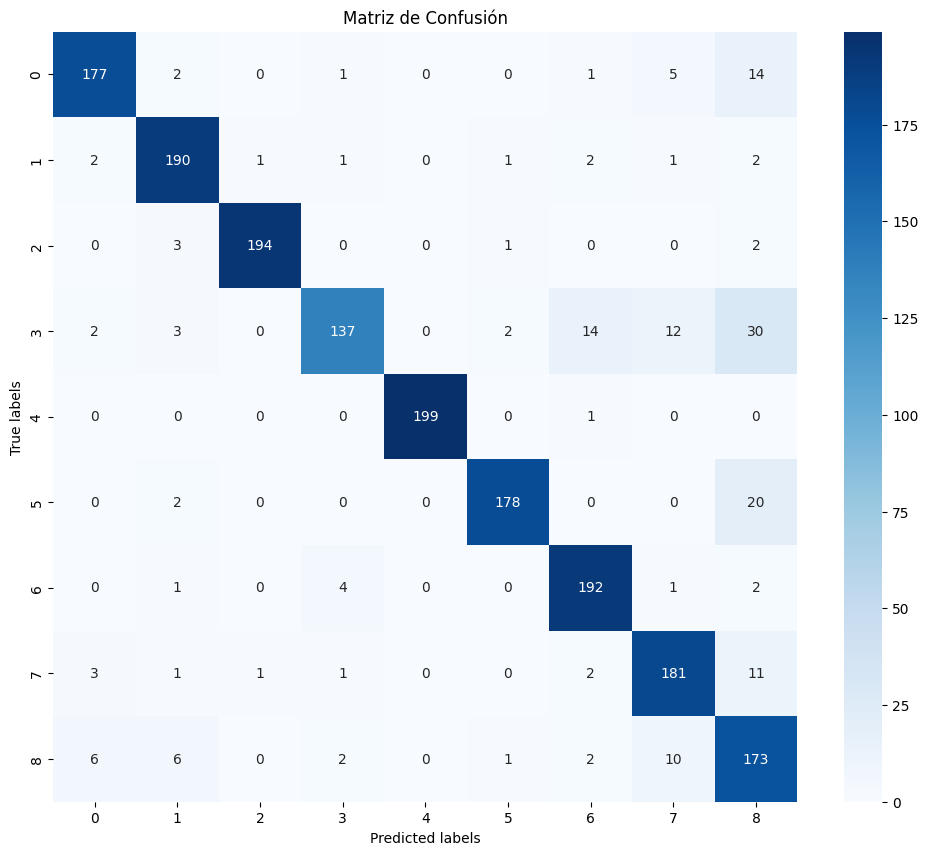

In [12]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(df["label"], df['predicted_label'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Matriz de Confusión")
plt.show()